# Model Training & Evaluation

In [1]:
import os
import pytorch_lightning as pl
import torch
import torchvision.transforms as T
from pytorch_lightning.callbacks import LearningRateMonitor

from dogs_cats_classifier.data import DogsCatsImagesDataModule
from dogs_cats_classifier.models import ResNet, Swin, ResNext
from dogs_cats_classifier.utils import Evaluator
from datetime import datetime

# Setup
## Training setting

In [2]:
batch_size = 16
max_epochs = 10
num_workers = os.cpu_count() // 4
image_size = (256, 256)
dataset_root = '../datasets/final/train'
fast_dev_run = False
seed = 168
model_type = 'swin_b'
accelerator = 'auto'
devices = None
output_path = '../model_weights'
use_lr_scheduler = True
use_auto_augment = True
finetune_last_layer = True
user_pretrained_weight = True

## Check output path

In [3]:
exp_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
print(exp_time)
output_path = os.path.join(output_path, f'{model_type}_{exp_time}')
# check output
if not os.path.exists(output_path):
    os.makedirs(output_path)

2022-11-01_23-32-41


## Setup random seed for reproducibility

In [4]:
# set all random seed
pl.seed_everything(seed, workers=True)

Global seed set to 168


168

## Setup dataset

In [5]:
# prepare dataset
train_t = []
if use_auto_augment:
    train_t.append(T.AutoAugment(T.AutoAugmentPolicy.IMAGENET))

train_t.append(T.Resize(image_size))
train_t.append(T.ToTensor())
train_t = T.Compose(train_t)
print('Training Data Augmentations')
print(train_t)

test_t = T.Compose([
    T.Resize(image_size),
    T.ToTensor(),
])

dogs_cats_datamodule = DogsCatsImagesDataModule(
    root=dataset_root,
    batch_size=batch_size,
    num_workers=num_workers,
    train_transforms=train_t,
    test_transforms=test_t,
    val_transforms=test_t,
    random_seed=seed,
)
print(dogs_cats_datamodule)

Training Data Augmentations
Compose(
    AutoAugment(policy=AutoAugmentPolicy.IMAGENET, fill=None)
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)
Dogs Cats Classification
#Labels: 1 = dog, 0 = cat
#Train: 20000
#Val: 2500
#Test: 2500


## Setup Model

In [6]:
# prepare model
if 'swin' in model_type:
    model = Swin
elif 'resnext' in model_type:
    model = ResNext
elif 'resnet' in model_type:
    model = ResNet
else:
    raise ValueError(f'{model_type} is not available.')

model = model(
    num_classes=1,
    model_type=model_type,
    input_shape=image_size,
    max_epochs=max_epochs,
    use_lr_scheduler=use_lr_scheduler,
    user_pretrained_weight=user_pretrained_weight,
    finetune_last_layer=finetune_last_layer,
)

# use pytorch lightning trainer
trainer = pl.Trainer(
    default_root_dir=output_path,
    accelerator=accelerator,
    devices=devices,
    max_epochs=max_epochs,
    auto_scale_batch_size=True,
    fast_dev_run=fast_dev_run,
    callbacks=[LearningRateMonitor(logging_interval='epoch')],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Training

In [7]:
# training
trainer.fit(model, datamodule=dogs_cats_datamodule)

Missing logger folder: ..\model_weights\swin_b_2022-11-01_23-32-41\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params | In sizes         | Out sizes
-----------------------------------------------------------------------------
0 | model     | SwinTransformer | 86.7 M | [1, 3, 256, 256] | [1, 1]   
1 | loss_func | BCELoss         | 0      | ?                | ?        
-----------------------------------------------------------------------------
1.0 K     Trainable params
86.7 M    Non-trainable params
86.7 M    Total params
346.977   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

C:\anaconda3\envs\dogs-cats-classifier\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Save scripted model weight

In [8]:
# save for use in production environment
script_model = model.to_torchscript()
torch.jit.save(script_model, os.path.join(output_path, 'model.pt'))

# Evaluation

100%|██████████| 1250/1250 [02:10<00:00,  9.59it/s]


Title: swin_b_train
Accuracy: 0.9935
Precision: 0.9916351324437364
Recall: 0.9954018392642943
AUC: 0.9993856249017001


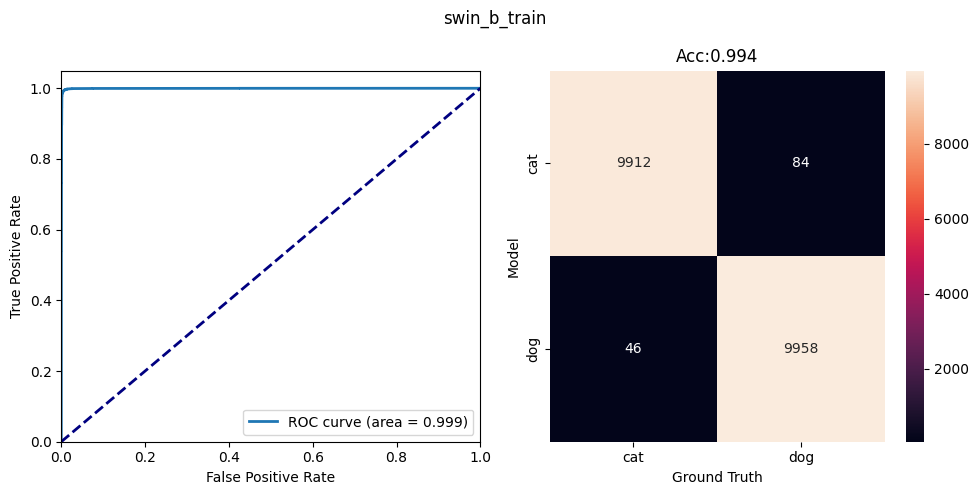

100%|██████████| 157/157 [00:25<00:00,  6.14it/s]


Title: swin_b_val
Accuracy: 0.9948
Precision: 0.9913249211356467
Recall: 0.9984114376489277
AUC: 0.9998291111411215


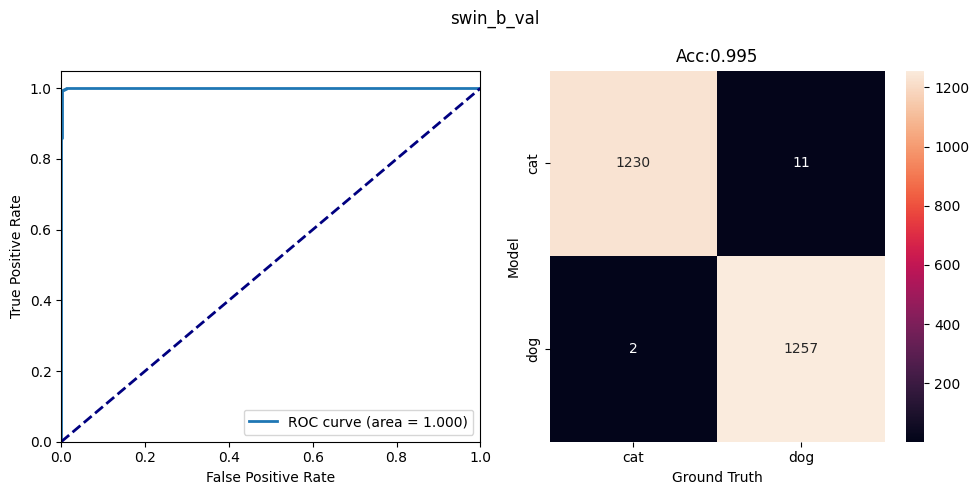

100%|██████████| 157/157 [00:25<00:00,  6.19it/s]


Title: swin_b_test
Accuracy: 0.9976
Precision: 0.9959709911361805
Recall: 0.9991915925626516
AUC: 0.9999385533539308


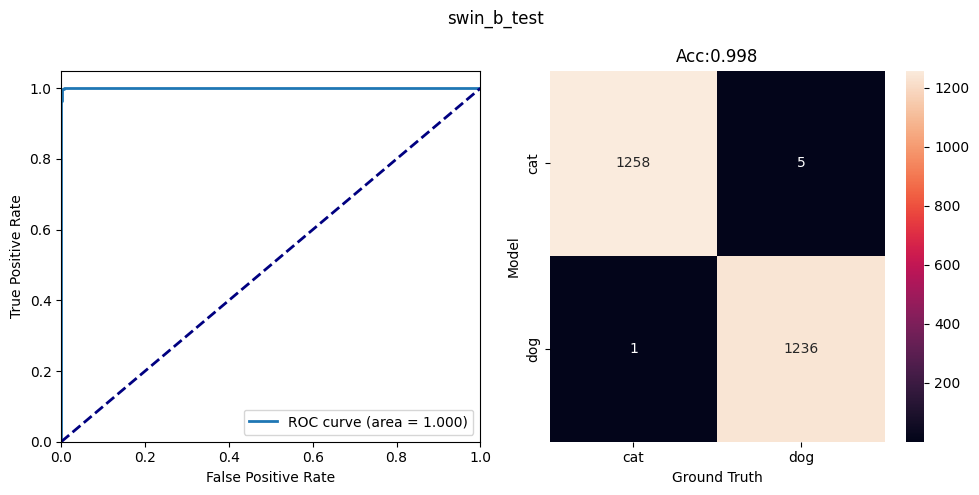

(array([1, 1, 1, ..., 0, 1, 1]),
 array([9.95645165e-01, 9.98622179e-01, 9.99755442e-01, ...,
        5.35556694e-07, 9.99470651e-01, 9.87823129e-01]),
 array([1, 1, 1, ..., 0, 1, 1]))

In [9]:
# evaluation
dogs_cats_datamodule.setup()
evaluator = Evaluator(model=model, output_path=output_path)
evaluator.evaluate(dataloader=dogs_cats_datamodule.train_dataloader(), title=f'{model_type}_train', verbose=True)
evaluator.evaluate(dataloader=dogs_cats_datamodule.val_dataloader(), title=f'{model_type}_val', verbose=True)
evaluator.evaluate(dataloader=dogs_cats_datamodule.test_dataloader(), title=f'{model_type}_test', verbose=True)